In [ ]:
import scipy
import os
import numpy as np
import pandas as pd
from fooof.utils.io import load_fooofgroup as load_fooofgroup
from natsort import natsorted 
import matplotlib as mpl
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 14})
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, zscore
import pickle
from data_utils import reorganize_rois, reorder_hemispheres, compare_slopes, mat_struct_to_dict


<module 'data_utils' from 'c:\\Users\\simon\\OneDrive\\Desktop\\git_paper\\data_utils.py'>

In [ ]:
### LOADING ROIs NAME FROM EEGLAB DESIKAN ATLAS ###
labels = pd.read_excel('path/to/EEGLAB/Desikan/atlas/xlsx').values.tolist()
labels = [parcel_name[0].replace("'", "") for parcel_name in labels]
print(f'ROIs names: {labels}')

ROIs names: ['bankssts L', 'bankssts R', 'caudalanteriorcingulate L', 'caudalanteriorcingulate R', 'caudalmiddlefrontal L', 'caudalmiddlefrontal R', 'cuneus L', 'cuneus R', 'entorhinal L', 'entorhinal R', 'frontalpole L', 'frontalpole R', 'fusiform L', 'fusiform R', 'inferiorparietal L', 'inferiorparietal R', 'inferiortemporal L', 'inferiortemporal R', 'insula L', 'insula R', 'isthmuscingulate L', 'isthmuscingulate R', 'lateraloccipital L', 'lateraloccipital R', 'lateralorbitofrontal L', 'lateralorbitofrontal R', 'lingual L', 'lingual R', 'medialorbitofrontal L', 'medialorbitofrontal R', 'middletemporal L', 'middletemporal R', 'paracentral L', 'paracentral R', 'parahippocampal L', 'parahippocampal R', 'parsopercularis L', 'parsopercularis R', 'parsorbitalis L', 'parsorbitalis R', 'parstriangularis L', 'parstriangularis R', 'pericalcarine L', 'pericalcarine R', 'postcentral L', 'postcentral R', 'posteriorcingulate L', 'posteriorcingulate R', 'precentral L', 'precentral R', 'precuneus L'

In [ ]:
### LOADING EXCEL FILE WITH THE INDICES Of EPILEPTOGENICS ROIs FOR EACH SUBJECT ###
file_path = "path/to/epi/ROIs/xlsx" 
df_relevant_rois = pd.read_excel(file_path)
# Extract indices and IDs
list_indices =  list(zip(df_relevant_rois["ID"].tolist(), list(df_relevant_rois["INDICES_strict"].tolist())))

In [ ]:
import pickle

# Load the dictionary from the file
with open("path/to/power/spectra/pickle/file", 'rb') as file:
    power_spectrum_dict = pickle.load(file)

In [ ]:
### LOADING POWER SPECTRUM FREQS ###
loaded_data = scipy.io.loadmat("path/to/power/spectra/pickle/file", struct_as_record=False, squeeze_me=True)
# choosing a random subject to load the frequencies data
sprint_dict = mat_struct_to_dict(loaded_data['SJ_10_sz1_Sprint'])
freqs = sprint_dict['Freqs']
del loaded_data
del sprint_dict

In [ ]:
def process_power_spectrum(power_spectrum_dict, freqs, list_indices, compensated_1_over_f=True, normalized="per ROIs"): 
    """
    Process and analyze power spectra data across selected and non-selected ROIs,
    with optional 1/f compensation and normalization, returning time-averaged
    power values across canonical frequency bands.

    Parameters
    ----------
    power_spectrum_dict : dict
        Dictionary where each key is a subject ID and the value is a 3D NumPy array
        of shape (n_ROIs, n_timepoints, n_freqs) representing the power spectrum.
    
    freqs : np.ndarray
        1D array of frequency values corresponding to the last axis of the power spectrum arrays.
    
    list_indices : list of tuples
        List of tuples (subject_id, indices), where `indices` is a comma-separated string
        representing the selected ROIs for that subject.
    
    compensated_1_over_f : bool, optional
        If True, compensates the power spectrum by multiplying it with the frequency array,
        effectively flattening the 1/f component (default is True).
    
    normalized : {"none", "per ROIs", "per subject"}, optional
        Specifies the normalization method:
        - "none": no normalization
        - "per ROIs": global z-score normalization across all subjects
        - "per subject": z-score normalization applied individually to each subject
        (default is "per ROIs").

    Returns
    -------
    time_avg_data_selected : dict
        Dictionary with frequency bands as keys and arrays of shape (n_timepoints,)
        representing the average time course of Epileptogenics ROIs across subjects.
    
    time_std_data_selected : dict
        Dictionary with frequency bands as keys and arrays of shape (n_timepoints,)
        representing the standard deviation across subjects for Epileptogenics ROIs.
    
    time_avg_data_non_selected : dict
        Same as `time_avg_data_selected` but for non-Epileptogenics ROIs.
    
    time_std_data_non_selected : dict
        Same as `time_std_data_selected` but for non-Epileptogenics ROIs.
    """
    # Validate normalization method
    valid_normalization_options = {"none", "per ROIs", "per subject"}
    if normalized not in valid_normalization_options:
        raise ValueError(f"Invalid normalization option '{normalized}'. Choose from {valid_normalization_options}.")

    compensated_1f_power = power_spectrum_dict.copy()
    if compensated_1_over_f:
        compensated_1f_power = {subj: data * freqs for subj, data in power_spectrum_dict.items()}
    
    avg_selected , avg_not_selected = {}, {}
    # Process each ID and its corresponding indices
    for ID, indices in list_indices:
        if ID in compensated_1f_power:
            matrix = compensated_1f_power[ID]  # Shape (68, 120, 2346)

            # Convert indices from string to list of integers
            selected_indices = list(map(int, indices.split(",")))
            # Select columns corresponding to the indices
            selected_values = matrix[selected_indices, :, :]  # Shape (selected_indices, 120, 2346)
            not_selected_values = np.delete(matrix, selected_indices, axis=0)  # Remaining columns
            del matrix
            # Compute averages
            avg_selected[ID] = selected_values
            avg_not_selected[ID] = not_selected_values
            del selected_values, not_selected_values
    
    if normalized == "per ROIs":
        # Flatten all data into a single array for global mean/std
        all_selected_values = np.concatenate([values.reshape(-1) for values in avg_selected.values()])
        all_not_selected_values = np.concatenate([values.reshape(-1) for values in avg_not_selected.values()])

        # Compute global mean and std
        mean_all_selected, std_all_selected = np.mean(all_selected_values), np.std(all_selected_values)
        mean_all_not_selected, std_all_not_selected = np.mean(all_not_selected_values), np.std(all_not_selected_values)

        # Apply z-score normalization across all subjects
        for key in avg_selected:
            avg_selected[key] = (avg_selected[key] - mean_all_selected) / std_all_selected
        for key in avg_not_selected:
            avg_not_selected[key] = (avg_not_selected[key] - mean_all_not_selected) / std_all_not_selected

    elif normalized == "per subject":
        # Normalize each subject separately
        for key in avg_selected:
            mean_selected, std_selected = np.mean(avg_selected[key]), np.std(avg_selected[key])
            avg_selected[key] = (avg_selected[key] - mean_selected) / std_selected

        for key in avg_not_selected:
            mean_not_selected, std_not_selected = np.mean(avg_not_selected[key]), np.std(avg_not_selected[key])
            avg_not_selected[key] = (avg_not_selected[key] - mean_not_selected) / std_not_selected

    # Define frequency bands
    bands = {
        "DELTA": (2, 4), "THETA": (5, 7), "ALPHA": (8, 12), 
        "BETA": (13, 30), "GAMMA": (30, 40)
    }
    
    # Initialize new dictionary to store filtered values
    freq_data_selected_rois = {band: {} for band in bands}
    freq_data_non_selected_rois = {band: {} for band in bands}

    # Iterate over subjects in data_dict
    for subject, data in avg_selected.items():
        for band, (low, high) in bands.items():
            # Get indices of frequencies within the range
            freq_indices = np.where((freqs >= low) & (freqs <= high))[0]
            # Select the corresponding values from the last axis (frequencies)
            freq_data_selected_rois[band][subject] = data[:, :, freq_indices]
    # Iterate over subjects in data_dict
    for subject, data in avg_not_selected.items():
        for band, (low, high) in bands.items():
            # Get indices of frequencies within the range
            freq_indices = np.where((freqs >= low) & (freqs <= high))[0]
            # Select the corresponding values from the last axis (frequencies)
            freq_data_non_selected_rois[band][subject] = data[:, :, freq_indices]

    time_avg_data_selected = {band: [] for band in bands}
    time_std_data_selected = {band: [] for band in bands}

    # Iterate over each frequency band
    for band in freq_data_selected_rois:
        for subject, data in freq_data_selected_rois[band].items():
            # data has shape (n_selected_rois x 120 x band_freqs)
            # Compute mean along the freqs and selected_rois axes
            time_avg_data_selected[band].append(np.mean(data, axis=(0, 2)))
        time_avg_data_selected[band] = np.mean(np.array(time_avg_data_selected[band]), axis = 0)
        time_std_data_selected[band] = np.std(np.array(time_avg_data_selected[band]), axis = 0)

    time_avg_data_non_selected = {band: [] for band in bands}
    time_std_data_non_selected = {band: [] for band in bands}

    # Iterate over each frequency band
    for band in freq_data_non_selected_rois:
        for subject, data in freq_data_non_selected_rois[band].items():
            # Compute mean along the time axis (axis=1)
            time_avg_data_non_selected[band].append(np.mean(data, axis=(0, 2)))
        time_avg_data_non_selected[band] = np.mean(np.array(time_avg_data_non_selected[band]), axis = 0)
        time_std_data_non_selected[band] = np.std(np.array(time_avg_data_non_selected[band]), axis = 0)
    
    return time_avg_data_selected, time_std_data_selected, time_avg_data_non_selected, time_std_data_non_selected

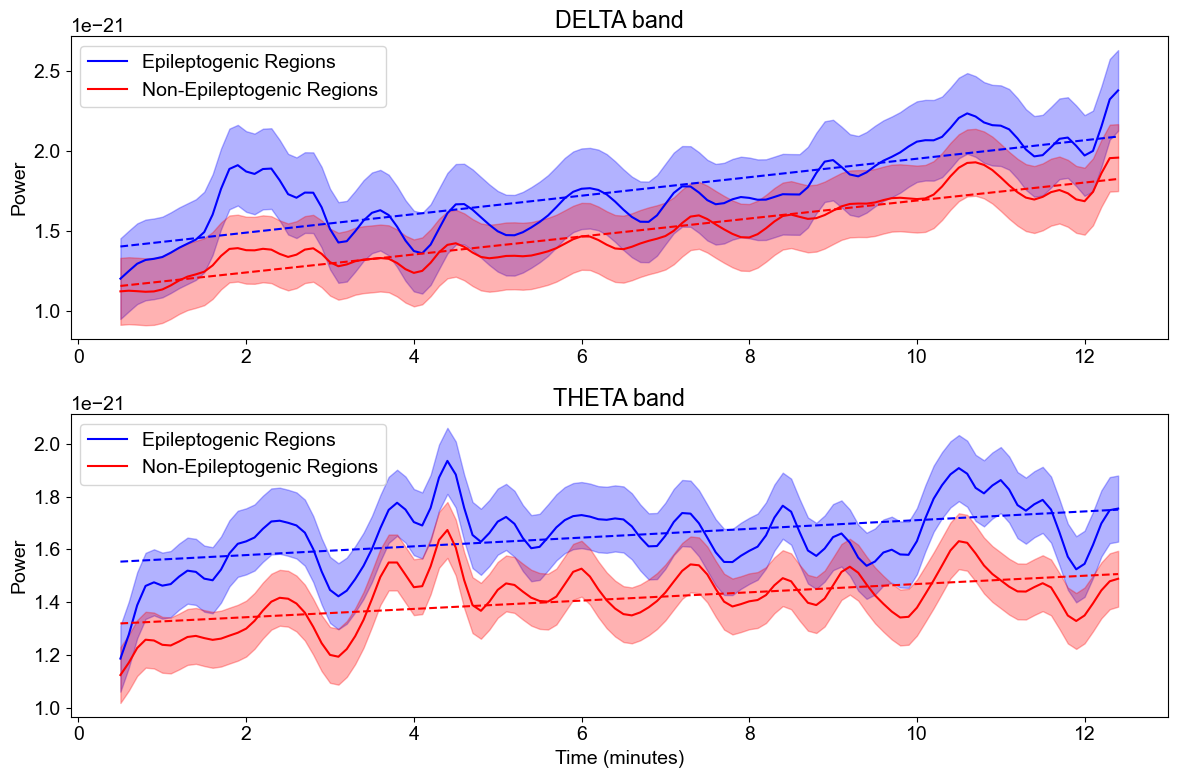

In [26]:
mean_selected_rois_compensated, std_selected_rois_compensated, mean_not_selected_rois_compensated, std_not_selected_rois_compensated  = process_power_spectrum(power_spectrum_dict, freqs, 
                                                                                                      list_indices, compensated_1_over_f = True, normalized = 'none')

# Create a figure and a set of subplots (5 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # 5 plots vertically stacked


# Parameters
sampling_rate = 256  # Hz
signal_duration_sec = 13 * 60  # 780 seconds
window_length_sec = 60
step_size_sec = window_length_sec * (1 - 0.9)  # 6 seconds
num_segments = 121  # already known

# Generate time vector (window centers) in seconds
window_start_times = np.arange(0, step_size_sec * num_segments, step_size_sec)
window_center_times = window_start_times + (window_length_sec / 2)

# Convert to minutes
window_center_times_min = (window_center_times / 60)[:120]

selected_bands = ['DELTA', 'THETA']
# Iterate through the dictionary and plot each band on a separate subplot
#for i, (band, values) in enumerate(plot_mean_selected.items()):
for i, band in enumerate(selected_bands):
    ax = axes[i]  # Get the subplot axis for the current band
    
    x = window_center_times_min

    # Plot Epileptogenic ROIs
    y_sel = mean_selected_rois_compensated[band]
    ax.plot(x, y_sel, label='Epileptogenic Regions', color='blue')
    ax.fill_between(x, y_sel - std_selected_rois_compensated[band], y_sel + std_selected_rois_compensated[band], color='blue', alpha=0.3)

    # Add linear regression for Epileptogenic ROIs
    coeffs_sel = np.polyfit(x, y_sel, 1)
    ax.plot(x, np.polyval(coeffs_sel, x), linestyle='--', color='blue')

    # Plot Non-Epileptogenic ROIs
    y_non = mean_not_selected_rois_compensated[band]
    ax.plot(x, y_non, label='Non-Epileptogenic Regions', color='red')
    ax.fill_between(x, y_non - std_not_selected_rois_compensated[band], y_non + std_not_selected_rois_compensated[band], color='red', alpha=0.3)

    # Add linear regression for Non-Epileptogenic ROIs
    coeffs_non = np.polyfit(x, y_non, 1)
    ax.plot(x, np.polyval(coeffs_non, x), linestyle='--', color='red')


    # Axis labels and title
    if i == 1:
        ax.set_xlabel("Time (minutes)")
    ax.set_ylabel("Power")
    ax.set_title(f"{band} band")
    
    # Add legend
    ax.legend(loc = 'upper left')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


In [14]:
compensated_delta_epi_nonepi = compare_slopes(mean_selected_rois_compensated['DELTA'], mean_not_selected_rois_compensated['DELTA'])
print(f'Comparison between delta power in epileptogenics ROIs vs non epileptogenics ROIs T = {compensated_delta_epi_nonepi["t_stat"]}, pval = {compensated_delta_epi_nonepi["p_value"]}')

compensated_theta_epi_nonepi = compare_slopes(mean_selected_rois_compensated['THETA'], mean_not_selected_rois_compensated['THETA'])
print(f'Comparison between theta power in epileptogenics ROIs vs non epileptogenics ROIs T = {compensated_theta_epi_nonepi["t_stat"]}, pval = {compensated_theta_epi_nonepi["p_value"]}')

Comparison between delta power in epileptogenics ROIs vs non epileptogenics ROIs T = 0.3413118315894265, pval = 0.7334758579325487
Comparison between theta power in epileptogenics ROIs vs non epileptogenics ROIs T = 0.2160972204023556, pval = 0.8292850853703418


#### RESTING STATE POWER ANALYSES ####

In [ ]:
def load_aperiodic_from_mat_files(parent_directory, aperiodic_component = 'exponent'):
    """
    Loads and extracts FOOOF aperiodic component data from all `.mat` files in the specified parent directory.
    This function iterates over all `.mat` files in the given directory, processes them by 
    and stores the results in a dictionary.

    Parameters:
    -----------
    parent_directory : str
        Path to the directory containing `.mat` files.
    aperiodic_component = str
        choose wich aperioding component to extract between 'exponent' and 'offset'

    Returns:
    --------
    data_dict : dict
        A dictionary where:
            - Keys are the subject names (extracted from file names, removing '_Sprint' if present).
            - Values are the extracted FOOOF exponent data from the `.mat` file.
    """
    # Initialize an empty dictionary to store results
    data_dict = {}

    # Iterate over each file in the parent directory, sorted naturally
    for file_name in natsorted(os.listdir(parent_directory)):  
        if file_name.endswith('.mat'):  # Consider only .mat files
            file_path = os.path.join(parent_directory, file_name)
            key_name = file_name.replace('.mat', '')
            dict_key = key_name.replace('_rest_SPRINT', '')

            print(f"Loading subject {dict_key} and extracting POWER SPECTRA data...")

            # Load .mat file
            mat_data = scipy.io.loadmat(file_path, struct_as_record=False, squeeze_me=True)

            # Convert MATLAB structure to dictionary
            sprint_dict = mat_struct_to_dict(mat_data[key_name])

            # Extract and store exponent data
            data_dict[dict_key] = sprint_dict['TF']

            # Free memory
            del sprint_dict  

    return data_dict

In [ ]:
#power_spectra_dict = load_aperiodic_from_mat_files("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\SPRINT_resting")

In [16]:
with open("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\SPRINT_resting\\resting_power_spectra.pkl", 'rb') as f:
    resting_power_spectra_dict = pickle.load(f)

In [17]:
list_indices_resting = [(key.split('_sz')[0], value) for key, value in list_indices]
list_indices_resting = natsorted(tuple(set(list_indices_resting)))

# removing 2 subjects that are not in the fooof exp interictal data
for index in [18,10]:
    del list_indices_resting[index]

In [18]:
resting_mean_selected_rois_compensated, resting_std_selected_rois_compensated, resting_mean_not_selected_rois_compensated, resting_std_not_selected_rois_compensated  = process_power_spectrum(resting_power_spectra_dict, freqs, 
                                                                                                      list_indices_resting, compensated_1_over_f = True, normalized = 'none')

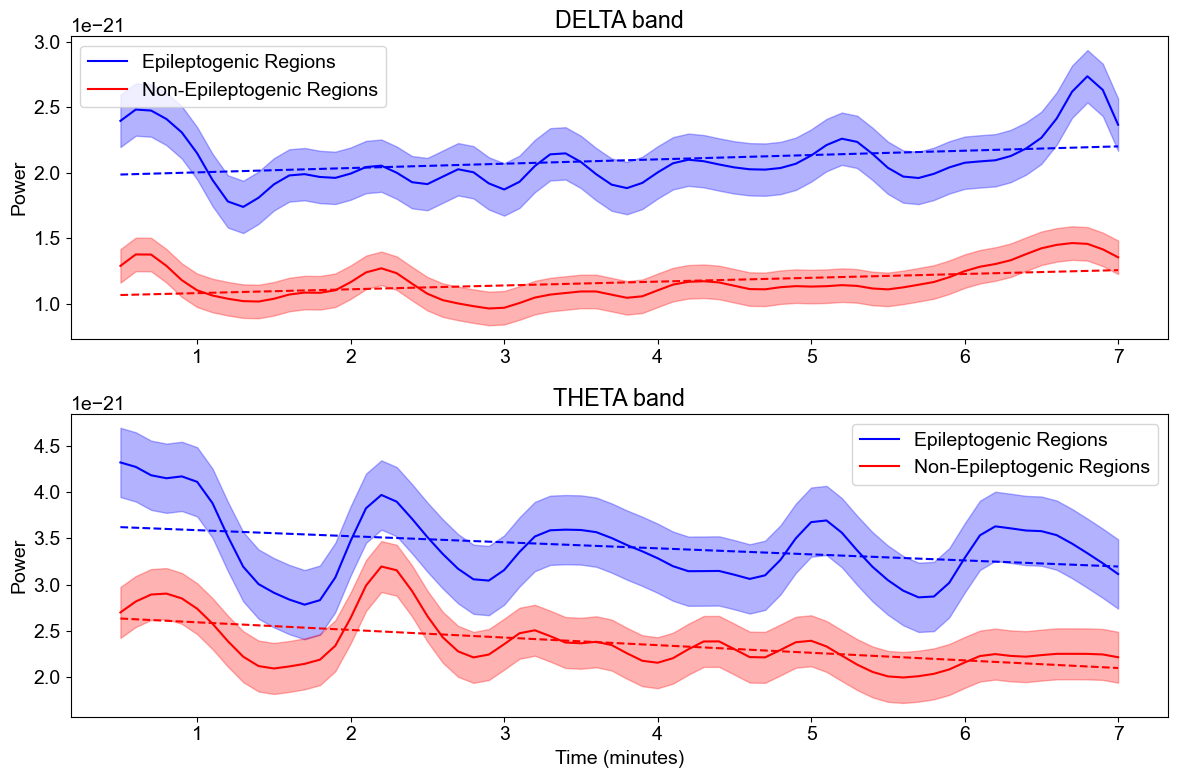

In [19]:
plot_mean_selected, plot_std_selected = resting_mean_selected_rois_compensated , resting_std_selected_rois_compensated
plot_mean_not_selected, plot_std_not_selected = resting_mean_not_selected_rois_compensated  , resting_std_not_selected_rois_compensated
# Create a figure and a set of subplots (5 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # 5 plots vertically stacked


# Parameters
sampling_rate = 256  # Hz
signal_duration_sec = 7.5 * 60  # 780 seconds
window_length_sec = 60
step_size_sec = window_length_sec * (1 - 0.9)  # 6 seconds
num_segments = 71  # already known

# Generate time vector (window centers) in seconds
window_start_times = np.arange(0, step_size_sec * num_segments, step_size_sec)
window_center_times = window_start_times + (window_length_sec / 2)

# Convert to minutes
window_center_times_min = (window_center_times / 60)[:66]


selected_bands = ['DELTA', 'THETA']
# Iterate through the dictionary and plot each band on a separate subplot
#for i, (band, values) in enumerate(plot_mean_selected.items()):
for i, band in enumerate(selected_bands):
    ax = axes[i]  # Get the subplot axis for the current band
    
    x = window_center_times_min

    # Plot Epileptogenic ROIs
    y_sel = plot_mean_selected[band]
    ax.plot(x, y_sel, label='Epileptogenic Regions', color='blue')
    ax.fill_between(x, y_sel - plot_std_selected[band], y_sel + plot_std_selected[band], color='blue', alpha=0.3)

    # Add linear regression for Epileptogenic ROIs
    coeffs_sel = np.polyfit(x, y_sel, 1)
    ax.plot(x, np.polyval(coeffs_sel, x), linestyle='--', color='blue')

    # Plot Non-Epileptogenic ROIs
    y_non = plot_mean_not_selected[band]
    ax.plot(x, y_non, label='Non-Epileptogenic Regions', color='red')
    ax.fill_between(x, y_non - plot_std_not_selected[band], y_non + plot_std_not_selected[band], color='red', alpha=0.3)

    # Add linear regression for Non-Epileptogenic ROIs
    coeffs_non = np.polyfit(x, y_non, 1)
    ax.plot(x, np.polyval(coeffs_non, x), linestyle='--', color='red')

    # Axis labels and title
    if i == 1:
        ax.set_xlabel("Time (minutes)")
    ax.set_ylabel("Power")
    ax.set_title(f"{band} band")
    
    # Add legend
    ax.legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


In [20]:
compensated_resting_delta_epi_nonepi = compare_slopes(resting_mean_selected_rois_compensated['DELTA'], resting_mean_not_selected_rois_compensated['DELTA'])
print(f'Comparison between RESTING delta power in epileptogenics ROIs vs non epileptogenics ROIs T = {compensated_resting_delta_epi_nonepi["t_stat"]}, pval = {compensated_resting_delta_epi_nonepi["p_value"]}')

compensated_resting_theta_epi_nonepi = compare_slopes(resting_mean_selected_rois_compensated['THETA'], resting_mean_not_selected_rois_compensated['THETA'])
print(f'Comparison between RESTING theta power in epileptogenics ROIs vs non epileptogenics ROIs T = {compensated_resting_theta_epi_nonepi["t_stat"]}, pval = {compensated_resting_theta_epi_nonepi["p_value"]}')

Comparison between RESTING delta power in epileptogenics ROIs vs non epileptogenics ROIs T = 0.2636666812361354, pval = 0.7928838781921598
Comparison between RESTING theta power in epileptogenics ROIs vs non epileptogenics ROIs T = 0.6121604101808316, pval = 0.5426004680403733


#### SLOPES COMPARISON BETWEEN PREICTAL AND INTERICTAL PERIOD IN DELTA AND THETA BANDS

In [21]:
compensated_resting_preictal_delta_epi_comp = compare_slopes(resting_mean_selected_rois_compensated['DELTA'], mean_selected_rois_compensated['DELTA'])
print(f'Comparison between INTERICTAL state and PREICTAL delta power in epileptogenics ROIs, T = {compensated_resting_preictal_delta_epi_comp["t_stat"]}, pval = {compensated_resting_preictal_delta_epi_comp["p_value"]}')

Comparison between INTERICTAL state and PREICTAL delta power in epileptogenics ROIs, T = -1.884340330633034, pval = 0.06406211177256668


In [22]:
compensated_resting_preictal_delta_nonepi_comp = compare_slopes(resting_mean_not_selected_rois_compensated['DELTA'], mean_not_selected_rois_compensated['DELTA'])
print(f'Comparison between INTERICTAL state and PREICTAL delta power in non epileptogenics ROIs, T = {compensated_resting_preictal_delta_nonepi_comp["t_stat"]}, pval = {compensated_resting_preictal_delta_nonepi_comp["p_value"]}')

Comparison between INTERICTAL state and PREICTAL delta power in non epileptogenics ROIs, T = -3.4403316765430643, pval = 0.0010278291974318587


In [24]:
compensated_resting_preictal_theta_epi_comp = compare_slopes(resting_mean_selected_rois_compensated['THETA'], mean_selected_rois_compensated['THETA'])
print(f'Comparison between INTERICTAL state and PREICTAL theta power in epileptogenics ROIs, T = {compensated_resting_preictal_theta_epi_comp["t_stat"]}, pval = {compensated_resting_preictal_theta_epi_comp["p_value"]}')

Comparison between INTERICTAL state and PREICTAL theta power in epileptogenics ROIs, T = -3.5087926999541796, pval = 0.0008295310008518215


In [25]:
compensated_resting_preictal_theta_nonepi_comp = compare_slopes(resting_mean_not_selected_rois_compensated['THETA'], mean_not_selected_rois_compensated['THETA'])
print(f'Comparison between INTERICTAL state and PREICTAL theta power in non epileptogenics ROIs, T = {compensated_resting_preictal_theta_nonepi_comp["t_stat"]}, pval = {compensated_resting_preictal_theta_nonepi_comp["p_value"]}')

Comparison between INTERICTAL state and PREICTAL theta power in non epileptogenics ROIs, T = -6.508143590632443, pval = 1.3459129648461256e-08
